Sample notebook for the text analysis using a Slack channel

### initial settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import japanize_matplotlib
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from zoneinfo import ZoneInfo

import slack_sdk
import emoji
import MeCab
_mecab_path = "-r /dev/null -d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd"

In [2]:
from morphogical_analysis_tool import (
    print_channel_ids, get_real_name, joint_messages_with_range,
    tokenize_with_pos, reduce_tokens, get_emoji_data
)

## define client and target channel

In [ ]:
_he_token = #{your Slack token here}
client = slack_sdk.WebClient(token=_he_token)

user_name = {}
all_members = client.users_list(token=_he_token)['members']
for _u in all_members:
    if (_u['name'] != 'slackbot') & _u['deleted'] == False:
        user_name[_u['id']] = _u['real_name']
    else:
        pass
user_name

### search channel ID and define the target

In [ ]:
print_channel_ids(client, _he_token)

In [ ]:
channel_id = # {your channel id here}
channel_name = # {your channel name here}

In [6]:
_start_date = datetime(2023, 1, 1, 0, 0, 0, tzinfo=ZoneInfo("UTC")).timestamp()
_stop_date = datetime(2025, 11, 12, 0, 0, 0, tzinfo=ZoneInfo("UTC")).timestamp()

request = client.conversations_history(
    channel=channel_id, limit=999, oldest=_start_date, latest=_stop_date)

# Analysis

## emoji and post frequency

In [ ]:
df0 = get_emoji_data(request, user_name=user_name)
df0

### emoji ranking

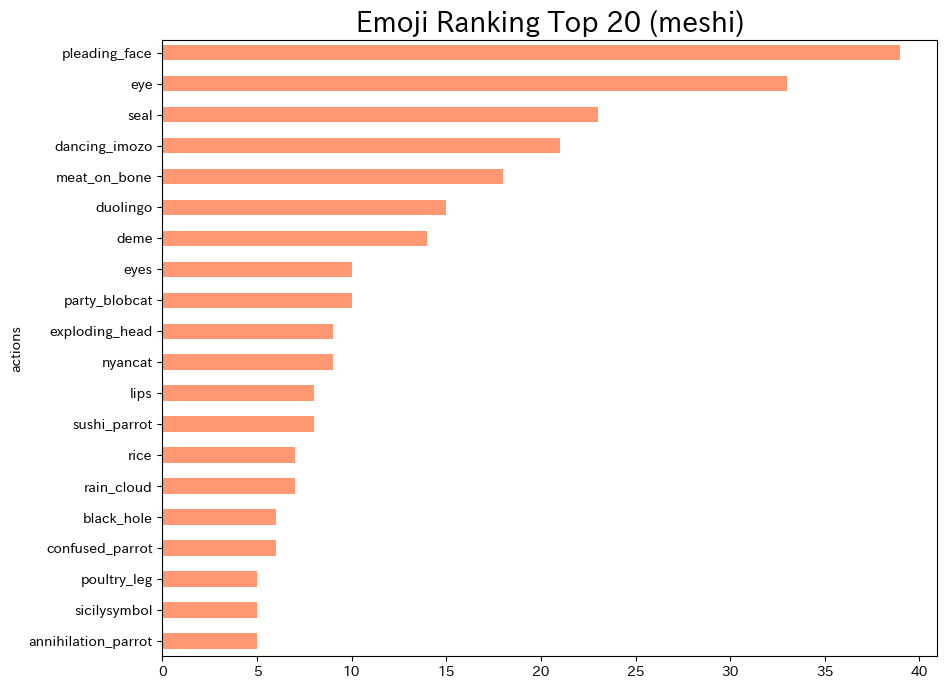

In [8]:
# plot the emoji ranking
_actions = []
for _a in df0['actions']:
    _actions.append(_a.split(','))
actions = sum(_actions, [])
df2 = pd.DataFrame(actions, columns=['actions'])
df2 = df2[df2['actions'] != 'no_emoji']
df2 = df2[df2['actions'] != '']
df2 = df2[df2['actions'] != 'text']

ax = plt.axes()
ax.set_title(f'Emoji Ranking Top 20 ({channel_name})', fontsize=20)
df2['actions'].value_counts().plot.barh(figsize=(10, 8), color='coral', alpha=0.8, ax=ax)
ax.set_ylim(-0.4,19.5)
ax.yaxis.set_inverted(True)

In [9]:
ruser = []
emoji0 = []
for _i in range(df0.shape[0]):
    ruser.append(df0['ruser'][_i].split(","))
    emoji0.append(df0['reactions'][_i].split(","))
rusers = sum(ruser, [])
emojis = sum(emoji0, [])
print(len(rusers), len(emojis))
df1 = pd.DataFrame({
    'ruser': rusers,
    'emojis': emojis
})
df1 = df1[df1['ruser'] != 'no_reply']

793 793


In [ ]:
fig = plt.figure(figsize=(3*7, 3*5+1))
fig.suptitle("emoji reactions in random channel", fontsize=20)
gs = GridSpec(6, 9, hspace=0.8, wspace=0.4)
for _i, _u in enumerate(df1['ruser'].unique()):
    ax = fig.add_subplot(gs[_i%6, _i//6])
    _df = df1[df1['ruser'] == _u]
    _df['emojis'].value_counts().plot.barh(
        ax=ax, color='lightblue', edgecolor='black')
    _keys = [_k[1] for _k in np.array(_df.value_counts().keys())]
    ax.set_title(_u)
    ax.set_xlim(0,18)
    ax.set_xlabel("count")
    ax.set_ylim(-0.5,4.5)
    ax.set_yticks(range(0, 5),)#labels=_keys[:5])
    ax.yaxis.set_inverted(True)

### coffee-break entries

In [8]:
def get_mins(x):
    x = datetime.fromtimestamp(float(x), tz=ZoneInfo("Asia/Tokyo"))
    mins = x.hour*60 + x.minute
    return mins
mins = []
for _ts in df0['ts']:
    mins.append(get_mins(_ts))
df0['mins'] = mins

In [ ]:
for _k, _v in df0['user'].value_counts().items():
    if _v > 10:
        print(f"{_k}: {_v}")
df0['counts'] = df0['user'].map(df0['user'].value_counts())

# sort df by value counts of user
df0 = df0.sort_values(by='counts', ascending=False)
df0 = df0.reset_index(drop=True)
df0 = df0[df0['counts'] >= 2]

In [ ]:
# plot histogram of ts in 1440 min range for each user label
fig = plt.figure(figsize=(16,3))
ax = plt.axes()
ax.set_title("Number of posts per persone in coffee-break channel (>=2 posts)")

for _i, _u in enumerate(df0['user'].unique()):
    _=ax.hist(df0['mins'][df0['user'] == _u], histtype='barstacked',
            bins=np.linspace(0, 1440, 4*24),
            alpha=0.8, label=f"{_i+1}: {_u}({df0['user'].value_counts()[_u]})",)

ax.set_xlabel("時間")
ax.set_xlim(0, 1440)
ax.set_xticks(np.arange(0, 1440, 60), [f"{i//60:02d}時" for i in range(0, 1440, 60)])

ax.legend(loc='upper left', ncol=3, fontsize=8)

### something else

# Morphological Analysis

### define stop words

In [7]:
uninteresting_tokens = [
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
    'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
    'v', 'w', 'x', 'y', 'z',
    'I', 'you', 'You', 'we', 'We', 'he', 'He', 'she', 'She', 'they', 'They',
    'me', 'my', 'mine', 'you', 'your', 'yours',
    'his', 'her', 'hers', 'its', 'our', 'ours', 'their', 'theirs', 'it', 'It',
    'am', 'are', 'is', 'was', 'were', 'be', 'been', 'being', 'them',
    'this', 'This', 'that', 'That', 'These', 'those',
    'what', 'which', 'who', 'whom', 'whose',
    'at', 'by', 'for', 'from', 'in', 'into', 'of', 'on', 'to', 'with',
    'an', 'the', 'The', 'and', 'has', 'will',
    'as', 'As', 'if', 'but', 'some',
    'like', 'need', 'been', 'have',
    'any', 'now', 'not', 'or', 'here', 'one',
    'all', 'someone', 'take', 'just', 'other', 'know',
    'about', 'able', 'next', 'can', 'ask', 'if',
    'If', 'only', 'made', 'write', 'would', 'below',
    'https', 'www', '.com', 'ac.jp', 'u.', 'please',
    'ｗｉ', 'ｆｉ',
    'ア', 'イ', 'ウ', 'エ', 'オ',
    'こと', 'よう', 'ため', 'ない', 'いる', 'する', 'ある', 'の',
    'これ', 'それ', 'あれ', 'どれ', 'もの', 'そう', 'ところ',
    '月日', '号', '号室', '*', '%',
]

uninteresting_numbers = [str(i) for i in range(100)] +['0'+str(i) for i in range(10)] + ['-'+str(i) for i in range(1, 10)] + [str(i)+'%' for i in range(1, 100)] + ['１', '２', '３', '４', '５', '６', '７', '８', '９', '０']

In [8]:
#stopwordsの指定
with open("./English_stopwords.txt","r") as f:
    stopwords0 = f.read().split("\n")

with open("./Japanese_stopwords.txt","r") as f:
    stopwords1 = f.read().split("\n")

stopwords = list(set(
    stopwords0 + stopwords1 + uninteresting_tokens + uninteresting_numbers
    ))

### get full text and remove urls

In [9]:
import re
url_pattern = r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+'
full_text = joint_messages_with_range(request)
full_text = re.sub(url_pattern, '', full_text)

In [ ]:
# tokens_with_pos = tokenize_with_pos(full_text, _mecab_path)
# df0 = pd.DataFrame(tokens_with_pos, columns=['token', 'pos', 'pos2'])
# df0 = df0[df0['pos2'] == '固有名詞']
# #df0 = df0[df0['pos'] == '名詞']
# df0 = df0[~df0['token'].isin(uninteresting_tokens)]
# #df = df[~np.in1d(df['token'], uninteresting_tokens)]
# df0 = df0['token'].value_counts().reset_index()
# df0.columns = ['token', 'count']
# df0 = df0[df0['count'] > 1]
# df0 = df0.sort_values('count', ascending=False)
# df0 = df0.reset_index(drop=True)

In [10]:
import re
def mecab_tokenizer(text):

    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    # replaced_text = re.sub(r'\d+\.*\d*', '', replaced_text) #数字を0にする

    # path = "-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
    # mecab = MeCab.Tagger(path)
    mecab = MeCab.Tagger(_mecab_path)
    parsed_lines = mecab.parse(replaced_text).split("\n")[:-2]

    # #表層形を取得
    # surfaces = [l.split('\t')[0] for l in parsed_lines]
    #原形を取得
    # token_list = [l.split("\t")[1].split(",")[6] for l in parsed_lines]
    token_list = [re.split('[\t,]', l)[0] for l in parsed_lines]
    #品詞を取得
    pos = [re.split('[\t,]', l)[1] for l in parsed_lines]
    # 名詞のみに絞り込み
    target_pos = ["名詞"]
    token_list = [t for t, p in zip(token_list, pos) if p in target_pos]

    # stopwordsの除去
    # stopwords = set(uninteresting_tokens)
    token_list = [t for t in token_list if t  not in stopwords]

    # ひらがなのみの単語を除く
    kana_re = re.compile("^[ぁ-ゖ]+$")
    token_list = [t for t in token_list if not kana_re.match(t)]

    return token_list

In [11]:
sentences = [mecab_tokenizer(sentence) for sentence in full_text.split("。")]
sentences[0], len(sentences)

(['318', 'meeting', 'owl', '調子'], 1579)

In [ ]:
import itertools
sentences = [mecab_tokenizer(sentence) for sentence in full_text.split("。")]
sentences_combs = [list(itertools.combinations(sentence,2)) for sentence in sentences]
words_combs = [[tuple(sorted(words)) for words in sentence] for sentence in sentences_combs]
target_combs = []
for words_comb in words_combs:
    target_combs.extend(words_comb)

import collections
ct = collections.Counter(target_combs)

import pandas as pd
df = pd.DataFrame([{"1番目" : i[0][0], "2番目": i[0][1], "count":i[1]} for i in ct.most_common()])
print(df.shape)
df.head(20)

In [13]:
def kyoki_word_network(df):
    from pyvis.network import Network
    import pandas as pd


    got_net = Network(height="1000px", width="95%", bgcolor="#FFFFFF", font_color="black", notebook=True)

    got_net.force_atlas_2based()
    # got_data = df[:150]
    got_data = df[df['count'] >= 3]

    sources = got_data['1番目']#count
    targets = got_data['2番目']#first
    weights = got_data['count']#second

    edge_data = zip(sources, targets, weights)

    for e in edge_data:
        src = e[0]
        dst = e[1]
        w = e[2]

        got_net.add_node(src, src, title=src)
        got_net.add_node(dst, dst, title=dst)
        got_net.add_edge(src, dst, value=w)

    neighbor_map = got_net.get_adj_list()

    for node in got_net.nodes:
        node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
        node["value"] = len(neighbor_map[node["id"]])

    got_net.show_buttons(filter_=['nodes', 'edges', 'physics'])
    return got_net

In [14]:
got_net = kyoki_word_network(df)
got_net.show("kyoki_random.html")
from IPython.display import HTML
# HTML("/content/kyoki.html")

In [15]:
uninterested2 = [
    'zoom', 'Zoom', 'photo', 'photos', 'pdf', 'jp', 'join', 'today', 'tomorrow', 'floor', 'PC',
    'Please', 'web', 'Web', 'ing', '.jp', 'post', 'link', 'plan', 'room', 'wifi',
    'ht', 'ml',
    '-1','-2', '-3', '-4', '-5', '-6', '-7', '-8', '-9', '-10',
    'よろしくお願いします', 'ありません',
]

stopwords1 = list(set(stopwords0 + stopwords1 + uninteresting_tokens + uninterested2))

In [18]:
_test = mecab_tokenizer(full_text)

In [ ]:
# _list = df0['token'].tolist()
_list = _test
words_wakachi = [word for word in _list if word not in stopwords1]
print(words_wakachi), print(len(words_wakachi))

In [21]:
from matplotlib import font_manager
from wordcloud import WordCloud
import os

# 候補（入っていそうな順）
candidates = [
    "IPAexGothic",        # Homebrew等で入れやすい
    "Hiragino Sans",      # macOS標準（ヒラギノ角ゴ）
    "Hiragino Kaku Gothic ProN",
    "Yu Gothic",
    "Noto Sans CJK JP",
    "Source Han Sans JP"
]

font_path = None
for name in candidates:
    try:
        path = font_manager.findfont(name, fallback_to_default=False)
        if os.path.exists(path):
            font_path = path
            break
    except Exception:
        pass

if font_path is None:
    raise FileNotFoundError("日本語フォントが見つかりません。IPAexGothic などをインストールしてください。")

print("Using font:", font_path)

my_stopwords = set(uninteresting_tokens)

word_cloud_general = WordCloud(
    font_path=font_path,
    width=1600, height=900,
    stopwords=my_stopwords,
    prefer_horizontal=1,
    min_font_size=5,
    collocations=False,
    background_color="white",
    max_words=4000
).generate(words_wakachi if isinstance(words_wakachi, str) else " ".join(words_wakachi))


Using font: /opt/homebrew/Caskroom/miniforge/base/envs/slack/lib/python3.10/site-packages/japanize_matplotlib/fonts/ipaexg.ttf


In [ ]:
figure = plt.figure(figsize=(16,9))
plt.imshow(word_cloud_general)
plt.tick_params(labelbottom=False, labelleft=False)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
# fig = plt.figure(figsize=(18,3))
# plt.bar(df0['token'][:100], df0['count'][:100])
# plt.title('Top 100 proper nouns in random channel')
# plt.xticks(rotation=90)
# plt.xlabel('token')
# plt.ylabel('count')
# plt.grid(lw=0.2)
# plt.ylim(0, 30)
# plt.xlim(-0.6, 99.6)

In [ ]:
# # get monthly messages and token
# _base_ts = datetime(2022, 4, 1, 0, 0, 0, tzinfo=ZoneInfo("Asia/Tokyo"))

# df = pd.DataFrame(columns=["start", "token", "count"])
# for _i in range(36):
#     start = _base_ts + relativedelta(months=_i)
#     stop = _base_ts + relativedelta(months=(_i+1))
#     #print(f"{start.strftime('%Y/%m/%d')} - {stop.strftime('%Y/%m/%d')}")
#     messages = get_messages_with_range(request, start, stop)
#     tokens_with_pos = tokenize_with_pos(messages)
#     _df = pd.DataFrame(tokens_with_pos, columns=["token", "pos", "subpos"])
#     _df = _df[_df["subpos"] == "固有名詞"]
#     # _df = _df[_df["pos"] == "名詞"]
#     _df = _df[~_df["token"].isin(unintersted_tokens)]
#     _df = _df['token'].value_counts().reset_index()
#     # if _i == 0:
#     #     print(_df)
#     _df = _df[_df['count'] >= 2]
#     _df.columns = ["token", "count"]
#     _df["start"] = start
#     _df = _df.sort_values(by="count", ascending=False)
#     _df = _df.reset_index(drop=True)
#     df = pd.concat([df, _df], ignore_index=True)
# df = df.reset_index(drop=True)

In [ ]:
# fig = plt.figure(figsize=(36,6))
# gs = GridSpec(1, 12, figure=fig)
# for _i in range(12):
#     ax = fig.add_subplot(gs[0, _i])
#     _target_ts = _base_ts + relativedelta(months=_i)
#     ax.set_title(f"{_target_ts.strftime('%Y年%m月')}")
#     try:
#         _df = df[df["start"] == _target_ts]
#         _df.plot(x="token", y="count", kind="barh", ax=ax, legend=False)
#         ax.set_ylabel(None)
#         ax.set_xlim(0,18)
#         ax.set_ylim(-0.4,20.5)
#         ax.yaxis.set_inverted(True)
#         # remove the frame of the plots
#         ax.spines['top'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.tick_params(labelbottom=False)
#     except:
#         ax.spines['top'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
#         ax.spines['left'].set_visible(False)
#         ax.spines['right'].set_visible(False)
#         ax.tick_params(labelleft=False, labelbottom=False)
#         pass